In [1]:
import os
os.chdir('C:/Users/raffa/PycharmProjects/PortfolioProject')
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from src.data_exploration.data_exploration import *

In [2]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

import sys
!{sys.executable} -m pip install lightgbm

In [15]:
train_data = np.load( './data/train_test/train_data_lgb.npy')
test_data = np.load( './data/train_test/test_data_lgb.npy')
train_target = np.load( './data/train_test/train_target_lgb.npy')
test_target = np.load( './data/train_test/test_target_lgb.npy')

In [12]:
#train_data = np.delete(train_data,6,1)

In [62]:
train_data.shape, test_data.shape

((13540, 90), (1504, 90))

In [339]:
lin_model = LinearRegression()
lin_scores = cross_val_score(lin_model, train_data, train_target, scoring='neg_mean_absolute_percentage_error')

In [340]:
lin_scores = -lin_scores
print('Mean MAPE: %.3f (%.3f)' % (lin_scores.mean(), lin_scores.std()) )

Mean MAPE: 0.274 (0.008)


In [ ]:
scores = cross_val_score(model, train_data, train_target, 
                         scoring='neg_mean_absolute_percentage_error', 
                         cv=8,  fit_params={'callbacks': callbacks}, verbose=1)

In [388]:
scores = -scores
print('Mean MAPE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAPE: 0.149 (0.007)


In [21]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((12050, 90), (12050,), (1490, 90), (1490,))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.11, random_state=42)
eval_set = [(X_train, y_train), (X_val, y_val)]

In [36]:
model = LGBMRegressor(boosting_type='gbdt',
                      colsample_bytree = 0.9199999999999999,
                      reg_alpha = 93,
                      reg_lambda = 37,
                      learning_rate = 0.0837329237459536,
                      min_child_samples = 7,
                      min_split_gain = 6.0,
                      n_estimators = 10000,
                      num_leaves = 1740,
                      random_state = 42,
                      subsample = 0.6100000000000001,
                      subsample_freq = 1
                     )

In [12]:
model = LGBMRegressor(boosting_type='gbdt',
                      colsample_bytree = 0.99,
                      reg_alpha = 96,
                      reg_lambda = 18,
                      learning_rate = 0.004274977431336523,
                      min_child_samples = 5,
                      min_split_gain = 3.0,
                      n_estimators = 10000,
                      num_leaves = 1740,
                      random_state = 42,
                      subsample = 0.62,
                      subsample_freq = 1
                     )

In [37]:
eval_result = {}
callbacks=[lgb.log_evaluation(period=-1,show_stdv=False), lgb.record_evaluation(eval_result), lgb.early_stopping(100, verbose=True)] 

In [38]:
model.fit(X_train, y_train, eval_set=eval_set, eval_metric=['rmse','mae'], callbacks=callbacks)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	training's rmse: 102637	training's l1: 31974.3	training's l2: 1.05344e+10	valid_1's rmse: 128970	valid_1's l1: 57844.5	valid_1's l2: 1.66333e+10


LGBMRegressor(colsample_bytree=0.9199999999999999,
              learning_rate=0.0837329237459536, min_child_samples=7,
              min_split_gain=6.0, n_estimators=10000, num_leaves=1740,
              random_state=42, reg_alpha=93, reg_lambda=37,
              subsample=0.6100000000000001, subsample_freq=1)

In [39]:
val_pred = model.predict(X_val)
print(metrics.mean_absolute_percentage_error(y_val,val_pred),
      metrics.mean_absolute_error(y_val,val_pred),
      metrics.r2_score(y_val,val_pred))

0.13826115933367364 57844.49243141465 0.9045385348665909


In [26]:
val_pred = model.predict(X_val)
print(metrics.mean_absolute_percentage_error(y_val,val_pred),
      metrics.mean_absolute_error(y_val,val_pred),
      metrics.r2_score(y_val,val_pred))

0.13765657823288108 57273.82292734976 0.9032376462160792


In [82]:
eval_result['training'].keys()

odict_keys(['rmse', 'l1', 'l2'])

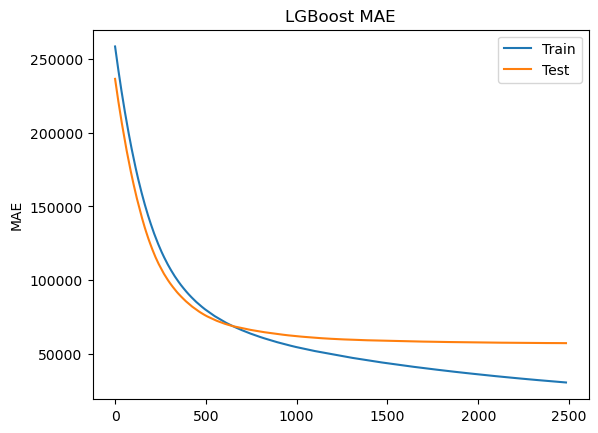

In [27]:
epochs = len(eval_result['training']['l1'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, eval_result['training']['l1'], label='Train')
ax.plot(x_axis, eval_result['valid_1']['l1'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('LGBoost MAE')
plt.show()

# Model tuning with optuna

In [3]:
import optuna 
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold, KFold
from optuna.integration import LightGBMPruningCallback

In [4]:
train = read_sqlite_table('train', './data/train_test/train_data_lgb.db')
test = read_sqlite_table('test', './data/train_test/test_data_lgb.db')
train_target = train['price']
train_data = train.drop('price', axis=1)
test_target = test['price']
test_data = test.drop('price', axis=1)

In [5]:
def objective(trial, X, y):
    param_grid = {
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "min_child_samples": trial.suggest_int("min_data_in_leaf", 0, 20, step=1),
        "reg_alpha": trial.suggest_int("lambda_l1", 0, 100, step=1),
        "reg_lambda": trial.suggest_int("lambda_l2", 0, 100, step=1),
        "min_split_gain": trial.suggest_float("min_gain_to_split", 0, 15, step=1),
        "subsample": trial.suggest_float(
            "subsample", 0.2, 0.99, step=0.01
        ),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float(
            "feature_fraction", 0.2, 0.99, step=0.01
        ),
    }

    cv = KFold(n_splits=8, shuffle=True, random_state=42)

    cv_scores = np.empty(8)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMRegressor(objective="rmse", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="rmse",
            callbacks=[
                lgb.early_stopping(100, verbose=False)
            ],  # Add a pruning callback
        )
        preds = model.predict(X_test)
        cv_scores[idx] = metrics.mean_absolute_error(y_test, preds)
    
    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")

In [9]:
func = lambda trial: objective(trial, train_data, train_target)

In [6]:
study = optuna.load_study(study_name="LGBM Regressor 1", storage="sqlite:///model/LGBMRegressor_study.db")

In [479]:
save_study = optuna.create_study(study_name="LGBM Regressor 1", storage="sqlite:///model/LGBMRegressor_study.db")
save_study.add_trials(study.trials)

[I 2023-06-24 22:23:28,995] A new study created in RDB with name: LGBM Regressor 1


In [11]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 66732.93505
	Best params:
		feature_fraction: 0.99
		lambda_l1: 96
		lambda_l2: 18
		learning_rate: 0.004274977431336523
		min_data_in_leaf: 5
		min_gain_to_split: 3.0
		n_estimators: 10000
		num_leaves: 1740
		random_state: 42
		subsample: 0.62
		subsample_freq: 1


In [ ]:
study.optimize(func, n_trials=500)

In [42]:
eval_result = {}
callbacks=[lgb.log_evaluation(period=-1,show_stdv=False), lgb.record_evaluation(eval_result)] 

In [43]:
model = LGBMRegressor(boosting_type='gbdt',
                      colsample_bytree = 0.9199999999999999,
                      reg_alpha = 93,
                      reg_lambda = 37,
                      learning_rate = 0.0837329237459536,
                      min_child_samples = 7,
                      min_split_gain = 6.0,
                      n_estimators = 225,
                      num_leaves = 1740,
                      random_state = 42,
                      subsample = 0.6100000000000001,
                      subsample_freq = 1
                     )

In [44]:
model.fit(train_data, train_target, callbacks=callbacks)

LGBMRegressor(colsample_bytree=0.9199999999999999,
              learning_rate=0.0837329237459536, min_child_samples=7,
              min_split_gain=6.0, n_estimators=225, num_leaves=1740,
              random_state=42, reg_alpha=93, reg_lambda=37,
              subsample=0.6100000000000001, subsample_freq=1)

In [45]:
model.booster_.save_model('./model/lgb_model_2.json')